# Imports

In [1]:
import pandas as pd
import utils
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Constants + Helper Functions

In [2]:
CONJUNCTION_COLORS = {
    "and": "#be0aff",
    "or": "#580aff",
    "but": "#0043ce",
    "nor": "#d12c19"
}

LIKE_UNLIKE_COLORS = {
    "likes": "#008bf8",
    "unlikes": "#dc0073"
}

CATEGORY_COLORS = {
    "NP": "#ee1266",
    "VP": "#6a4c93",
    "ADJP": "#1982c4",
    "ADVP": "#0ead69",
    "PP": "#ff4b35",
    "SBAR": "#00cecb"
}

CONJUNCTIONS = ['and', 'or', 'but', 'nor']

In [3]:
def get_df_from_path(path):
    '''
    Concatenate all CSV files in the specified path and return
    the result as a DataFrame.

    @param path (str): path to input CSV files
    @return (DataFrame): DataFrame containing all data
    '''
  
    all_files = glob.glob(path)

    # Concatenate all CSVs in the specified path into one dataframe
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    if li == []:
        return None

    df = pd.concat(li, axis=0, ignore_index=True)
    return df

In [4]:
def get_wordnet_dfs(df):
    '''
    Get five DataFrames for each WordNet relation (synonymy, antonymy,
    hypernymy, co-hyponymy, entailment) using examples from the given
    input df.

    @param df (DataFrame): input of raw coordination samples
    @return (5-tuple of DataFrames): tuple containing a DataFrame for each
        WordNet relation (synonymy_df, antonymy_df, hypernymy_df,
        cohyponymy_df, entailment_df)
    '''
    
    # Get like coordinations
    likes = utils.likes_df(df)

    # Finding closures over wordnet relations produces redundant search warnings
    # We'll just filter these warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Get wordnet relations for like coordinations
        synonymy_df = utils.analyze_synonymy(likes)
        antonymy_df = utils.analyze_antonymy(likes)
        hypernymy_df = utils.analyze_hypernymy(likes)
        cohyponymy_df = utils.analyze_cohyponymy(likes)
        entailment_df = utils.analyze_entailment(likes)

    return (synonymy_df, antonymy_df, hypernymy_df, cohyponymy_df, entailment_df)

# Load Data and Get WordNet Relations

In [5]:
# GUM
gum_samples = get_df_from_path('csv/GUM/*.csv')
gum_synonymy_df, gum_antonymy_df, gum_hypernymy_df, gum_cohyponymy_df, gum_entailment_df \
    = get_wordnet_dfs(gum_samples)

# EWT
ewt_samples = get_df_from_path('csv/EWT/*.csv')
ewt_synonymy_df, ewt_antonymy_df, ewt_hypernymy_df, ewt_cohyponymy_df, ewt_entailment_df \
    = get_wordnet_dfs(ewt_samples)

# All sources
all_synonymy_df = pd.concat([gum_synonymy_df, ewt_synonymy_df], axis=0, ignore_index=True)
all_antonymy_df = pd.concat([gum_antonymy_df, ewt_antonymy_df], axis=0, ignore_index=True)
all_hypernymy_df = pd.concat([gum_hypernymy_df, ewt_hypernymy_df], axis=0, ignore_index=True)
all_cohyponymy_df = pd.concat([gum_cohyponymy_df, ewt_cohyponymy_df], axis=0, ignore_index=True)
all_entailment_df = pd.concat([gum_entailment_df, ewt_entailment_df], axis=0, ignore_index=True)


# Synonyms

In [6]:
def get_synonyms_freqs(df):
    # Get synonyms
    syns = df.loc[(df['Synonyms?'] == True)]

    # Get counts
    syns_count = len(syns)
    tot = len(df)

    print('syns:', syns_count)
    print('not syns:', tot - syns_count)

    return syns_count / tot

### By conjunction

In [7]:
def synonym_conjunction_distribution(synonyms_df, outfile, source=None):

    labels = []
    syns_freqs = []

    for conjunction in CONJUNCTIONS:
        print(conjunction)

        labels.append(conjunction)

        df = synonyms_df.copy()
        df = df.loc[df['Conjunction'] == conjunction]

        if df is None:
            continue

        syns_freqs.append(get_synonyms_freqs(df))

    x = np.arange(len(labels))  # the label locations
    width = 0.6  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, syns_freqs, width, color=CONJUNCTION_COLORS.values())

    if source is not None:
        title = 'Percentages of Coordinations with Synonymy\nby Conjunction ({})'.format(
            source)
    else:
        title = 'Percentages of Coordinations with Synonymy\nby Conjunction'

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha='center', va='bottom', color='white')

    plt.savefig(outfile, bbox_inches='tight')


and
syns: 159
not syns: 5177
or
syns: 22
not syns: 666
but
syns: 18
not syns: 581
nor
syns: 1
not syns: 16
and
syns: 45
not syns: 2053
or
syns: 9
not syns: 308
but
syns: 6
not syns: 232
nor
syns: 1
not syns: 7
and
syns: 114
not syns: 3124
or
syns: 13
not syns: 358
but
syns: 12
not syns: 349
nor
syns: 0
not syns: 9


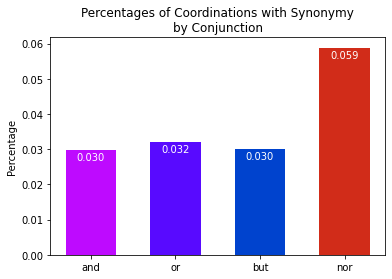

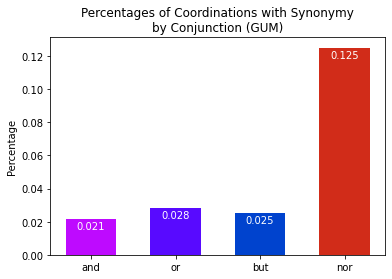

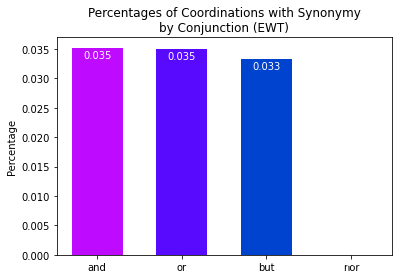

In [8]:
synonym_conjunction_distribution(all_synonymy_df, 'charts/synonymy_by_conjunction.pdf')
synonym_conjunction_distribution(gum_synonymy_df, 'charts/GUM_synonymy_by_conjunction.pdf', source='GUM')
synonym_conjunction_distribution(ewt_synonymy_df, 'charts/EWT_synonymy_by_conjunction.pdf', source='EWT')

### By category

In [9]:
def synonym_category_distribution(synonyms_df, outfile, source=None):
    labels = []
    syns_freqs = []

    nouns, verbs, adjps, advps = utils.likes_by_category(synonyms_df)

    print('Nominal')
    labels.append('Nominal')

    syns_freqs.append(get_synonyms_freqs(nouns))

    print('Verbal')
    labels.append('Verbal')

    syns_freqs.append(get_synonyms_freqs(verbs))

    print('Adjectival')
    labels.append('Adjectival')

    syns_freqs.append(get_synonyms_freqs(adjps))

    print('Adverbial')
    labels.append('Adverbial')

    syns_freqs.append(get_synonyms_freqs(advps))

    x = np.arange(len(labels))  # the label locations
    width = 0.6  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, syns_freqs, width, color=CATEGORY_COLORS.values())

    if source is not None:
        title = 'Percentages of Coordinations with Synonymy\nby Syntactic Category ({})'.format(
            source)
    else:
        title = 'Percentages of Coordinations with Synonymy\nby Syntactic Category'

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha='center', va='bottom', color='white')

    plt.savefig(outfile, bbox_inches='tight')


Nominal
syns: 37
not syns: 2318
Verbal
syns: 148
not syns: 3410
Adjectival
syns: 14
not syns: 608
Adverbial
syns: 1
not syns: 104
Nominal
syns: 13
not syns: 985
Verbal
syns: 41
not syns: 1326
Adjectival
syns: 6
not syns: 242
Adverbial
syns: 1
not syns: 47
Nominal
syns: 24
not syns: 1333
Verbal
syns: 107
not syns: 2084
Adjectival
syns: 8
not syns: 366
Adverbial
syns: 0
not syns: 57


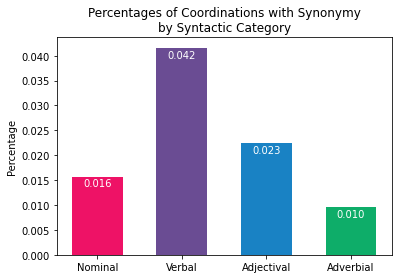

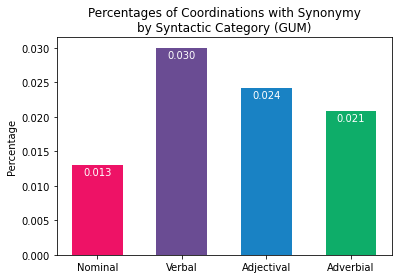

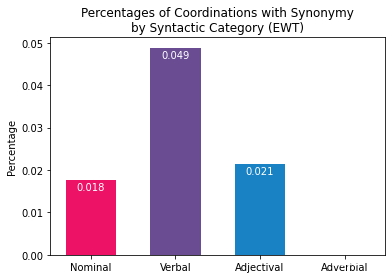

In [10]:
synonym_category_distribution(all_synonymy_df, 'charts/synonymy_by_category.pdf')
synonym_category_distribution(gum_synonymy_df, 'charts/GUM_synonymy_by_category.pdf', source='GUM')
synonym_category_distribution(ewt_synonymy_df, 'charts/EWT_synonymy_by_category.pdf', source='EWT')